# Example 8: RVT SRA with simulated profiles

Use RVT with simulated profiles to compute the surface response spectrum and surface spectral ratio.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
m = pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna')
m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=100), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 450),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=400), 30, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.ToroVelocityVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.InitialVelProfile(),
])

## Perform the calculation

In [8]:
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity,
        var_soiltypes=var_soiltypes
):
    # Here we auto-descretize the profile for wave propagation purposes
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

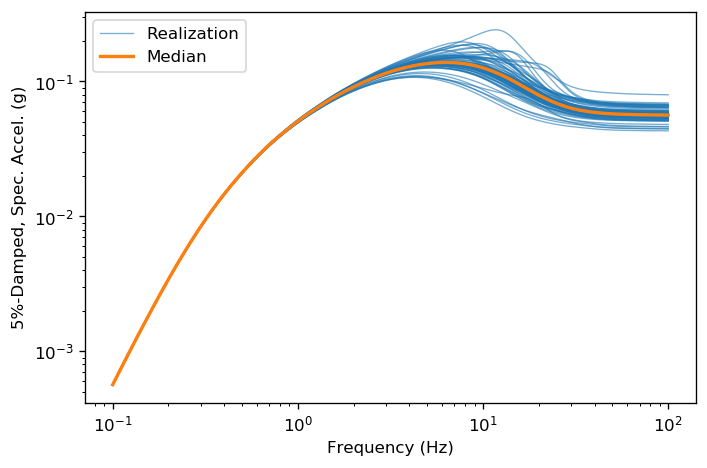

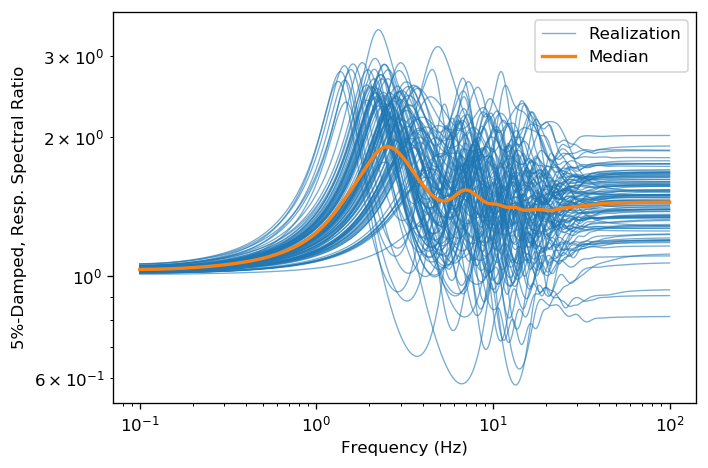

In [9]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

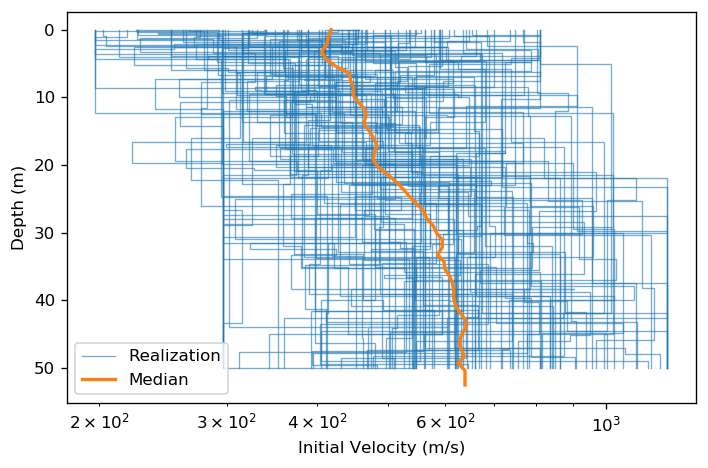

In [10]:
fig, ax = outputs[-1].plot()

The statistics of the output can be also retrieved and returned as either a `dict` or `pandas.DataFrame`.

In [11]:
outputs[-1].calc_stats()

{'ref': array([ 0.        ,  1.07142857,  2.14285714,  3.21428571,  4.28571429,
         5.35714286,  6.42857143,  7.5       ,  8.57142857,  9.64285714,
        10.71428571, 11.78571429, 12.85714286, 13.92857143, 15.        ,
        16.07142857, 17.14285714, 18.21428571, 19.28571429, 20.35714286,
        21.42857143, 22.5       , 23.57142857, 24.64285714, 25.71428571,
        26.78571429, 27.85714286, 28.92857143, 30.        , 31.07142857,
        32.14285714, 33.21428571, 34.28571429, 35.35714286, 36.42857143,
        37.5       , 38.57142857, 39.64285714, 40.71428571, 41.78571429,
        42.85714286, 43.92857143, 45.        , 46.07142857, 47.14285714,
        48.21428571, 49.28571429, 50.35714286, 51.42857143, 52.5       ]),
 'median': array([417.9310817 , 414.27052043, 412.32399419, 405.25051412,
        410.73823098, 423.58051114, 442.29454284, 444.54657675,
        448.54922019, 448.07340295, 455.16748021, 465.75606651,
        466.2669632 , 463.57456193, 472.03148223, 478.21860

In [12]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,417.931082,0.375110
1.071429,414.270520,0.385206
2.142857,412.323994,0.379599
3.214286,405.250514,0.357247
4.285714,410.738231,0.349336
5.357143,423.580511,0.360361
6.428571,442.294543,0.326244
7.500000,444.546577,0.313651
8.571429,448.549220,0.323427


## Repeat using a Generic Depth-Dependent Model

The generic `DepthDependToroVelVariation` follows the SPID guidance.

In [13]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model('USGS C')

In [14]:
outputs.reset()
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

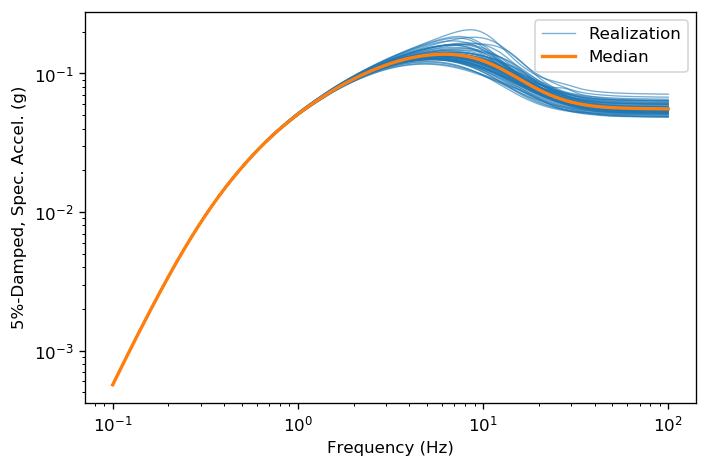

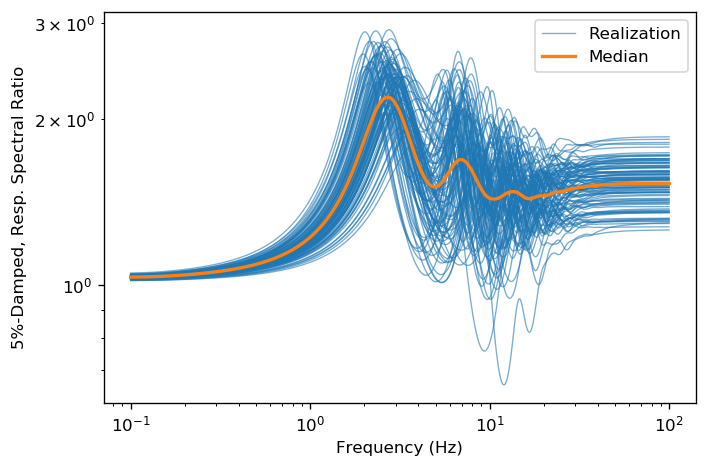

In [15]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

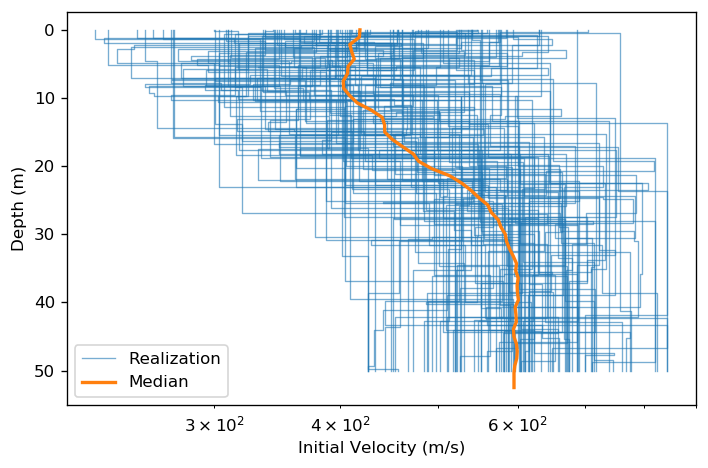

In [16]:
fig, ax = outputs[-1].plot()

In [17]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,418.575749,0.252607
1.071429,418.026180,0.253072
2.142857,409.008632,0.253055
3.214286,410.803292,0.233577
4.285714,413.188743,0.253766
5.357143,407.465185,0.252817
6.428571,406.840064,0.238472
7.500000,402.977114,0.243989
8.571429,403.376441,0.236609


## Repeat using a Specific Depth-Dependent Model

In [18]:
var_velocity_dd = pysra.variation\
    .DepthDependToroVelVariation.generic_model(
    'USGS C',
    depth=[0, 10, 20],
    ln_std=[0.25, 0.15, 0.10]
)

In [19]:
outputs.reset()
count = 100
for p in pysra.variation.iter_varied_profiles(
        profile,
        count,
        var_thickness=var_thickness,
        var_velocity=var_velocity_dd,
        var_soiltypes=var_soiltypes
):
    calc(m, p.auto_discretize(), p.location('outcrop', index=-1))
    outputs(calc)

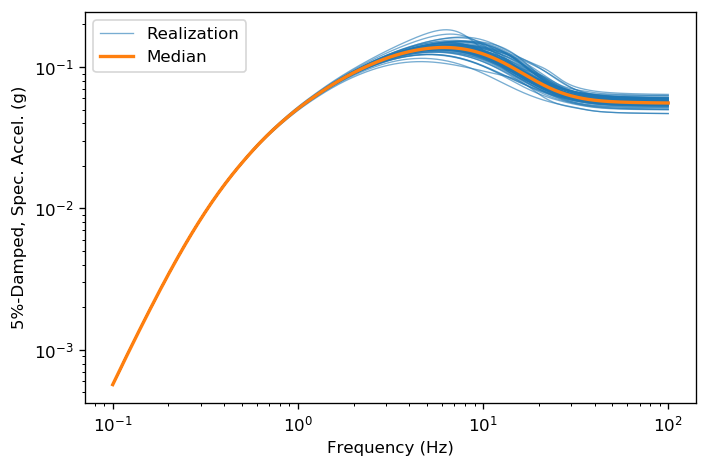

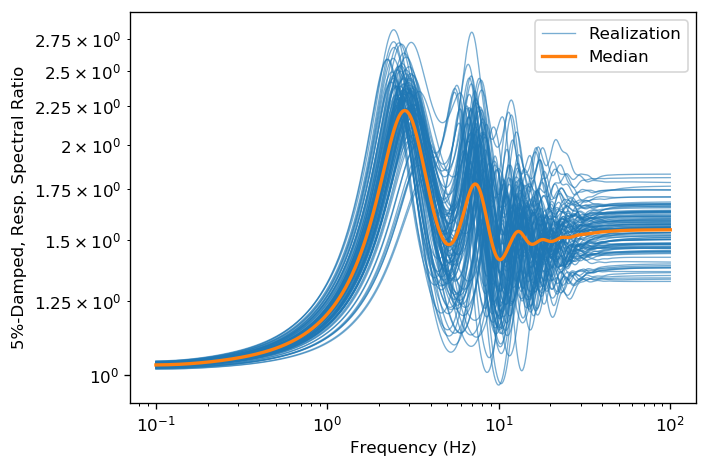

In [20]:
for o in outputs[:-1]:
    fig, ax = o.plot()
    fig;

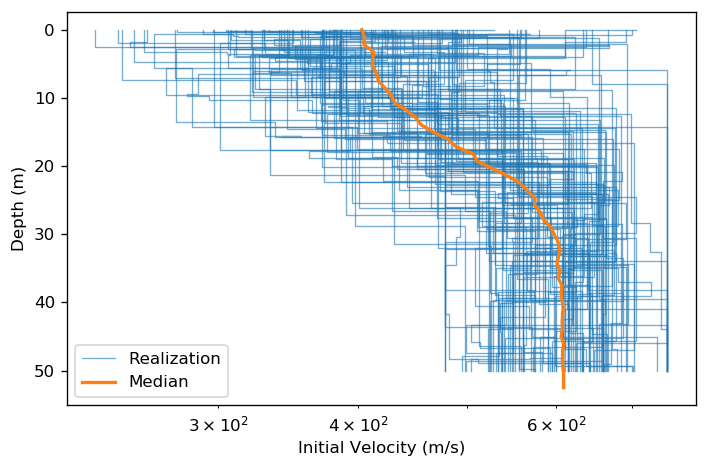

In [21]:
fig, ax = outputs[-1].plot()

In [22]:
outputs[-1].calc_stats(as_dataframe=True)

,median,ln_std
depth,,
0.000000,402.755645,0.247651
1.071429,405.005702,0.245355
2.142857,404.266704,0.245877
3.214286,412.673325,0.239067
4.285714,411.889352,0.225014
5.357143,411.497989,0.216826
6.428571,415.271640,0.205612
7.500000,416.639421,0.210335
8.571429,422.622216,0.203270
